In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel, RandomSearch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [8]:
# Define the directory paths
train_dir = 'A:/NTCC inhouse practical project/157/Training'
test_dir = 'A:/NTCC inhouse practical project/157/Testing'

In [9]:
# Create an ImageDataGenerator instance for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Adjusted brightness range
    validation_split=0.2,  # Percentage of data for validation from train_dir
)

# Only rescaling for testing data
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [10]:

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Set as training data
    shuffle=True  # Shuffle the training data
)

# Load the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    shuffle=False  # No need to shuffle validation data
)

# Load the testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure no shuffling for correct evaluation
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [11]:
# Define your model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fifth Convolutional Block
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling and fully connected layers
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))  # 4 output classes

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,839,300 (7.02 MB)

 Trainable params: 1,836,292 (7.00 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [12]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the entire model to a HDF5 file
model.save('brain_tumor_detection_model_2.h5')

# Ensure model is saved correctly
model_file_path = 'brain_tumor_detection_model_2.h5'
model.save(model_file_path)
print(f"Model saved to {model_file_path}")

# Save history to a file

history_file_path = 'training_history_2.pickle'
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)
print(f"Training history saved to {history_file_path}")

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.6149 - loss: 1.0948 - val_accuracy: 0.2550 - val_loss: 2.0182 - learning_rate: 1.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.7782 - loss: 0.6037 - val_accuracy: 0.2568 - val_loss: 4.8269 - learning_rate: 1.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8040 - loss: 0.5511 - val_accuracy: 0.4391 - val_loss: 2.6552 - learning_rate: 1.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8309 - loss: 0.4665 - val_accuracy: 0.5057 - val_loss: 1.8487 - learning_rate: 1.0000e-04
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8519 - loss: 0.4126 - val_accuracy: 0.7748 - val_loss: 0.5741 - learning_rate: 1.0000e-04
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.8616 - loss: 0.3977 - val_accuracy: 0.6345 - val_loss: 1.4570 - learning_rate: 1.0000e-04
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/ste

Model saved to brain_tumor_detection_model_2.h5
Training history saved to training_history_2.pickle


In [13]:
# Evaluate the model
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18432864546775818
Test accuracy: 0.9603356122970581


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 316ms/step - accuracy: 0.9515 - loss: 0.2337
Test accuracy: 96.03%


In [16]:
# Load the model
model_file_path = 'brain_tumor_detection_model_2.h5'
model = load_model(model_file_path)
print(f"Model loaded from {model_file_path}")

# Load the training history
history_file_path = 'training_history_2.pickle'
with open(history_file_path, 'rb') as file:
    history = pickle.load(file)
print(f"Training history loaded from {history_file_path}")

Model loaded from brain_tumor_detection_model_2.h5
Training history loaded from training_history_2.pickle


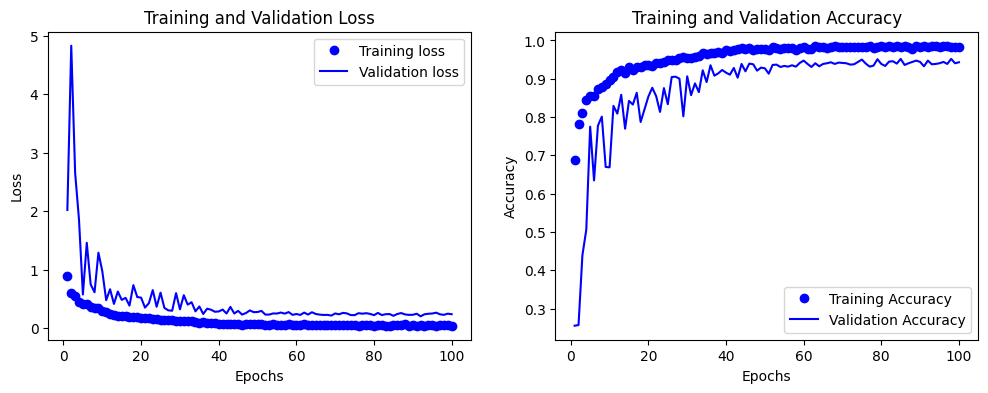

In [17]:

# Extract the values for loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history.get('accuracy')  # Use 'acc' if you're using an older version of Keras
val_acc = history.get('val_accuracy')  # Use 'val_acc' if you're using an older version of Keras

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step


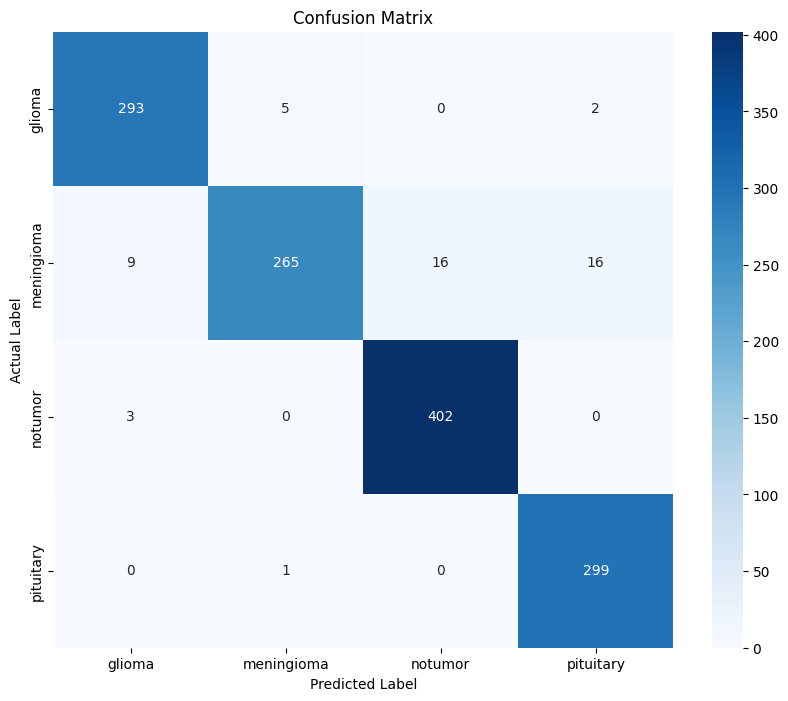

In [18]:
# Predict the probabilities from the test dataset
Y_pred_prob = model.predict(test_generator)

y_pred_prob = Y_pred_prob[:, 1]
# Convert probabilities to class labels
y_pred = np.argmax(Y_pred_prob, axis=1)
# Get the true labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [19]:
# Detailed classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')

# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall:.2f}')

# F1-Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-Score: {f1:.2f}')

Classification Report
              precision    recall  f1-score   support

      glioma       0.96      0.98      0.97       300
  meningioma       0.98      0.87      0.92       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.94      1.00      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1-Score: 0.96


In [20]:
# Create a performance matrix
performance_matrix = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [accuracy, precision, recall, f1]
}

# Convert to DataFrame for better visualization
performance_df = pd.DataFrame(performance_matrix)

# Display the performance matrix
print(performance_df)

      Metric     Score
0   Accuracy  0.960336
1  Precision  0.961010
2     Recall  0.960336
3   F1 Score  0.959622


In [21]:
# Calculate precision-recall curve and ROC-AUC for each class
n_classes = len(test_generator.class_indices)
precision = dict()
recall = dict()
pr_auc = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, Y_pred_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    fpr[i], tpr[i], _ = roc_curve(y_true == i, Y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

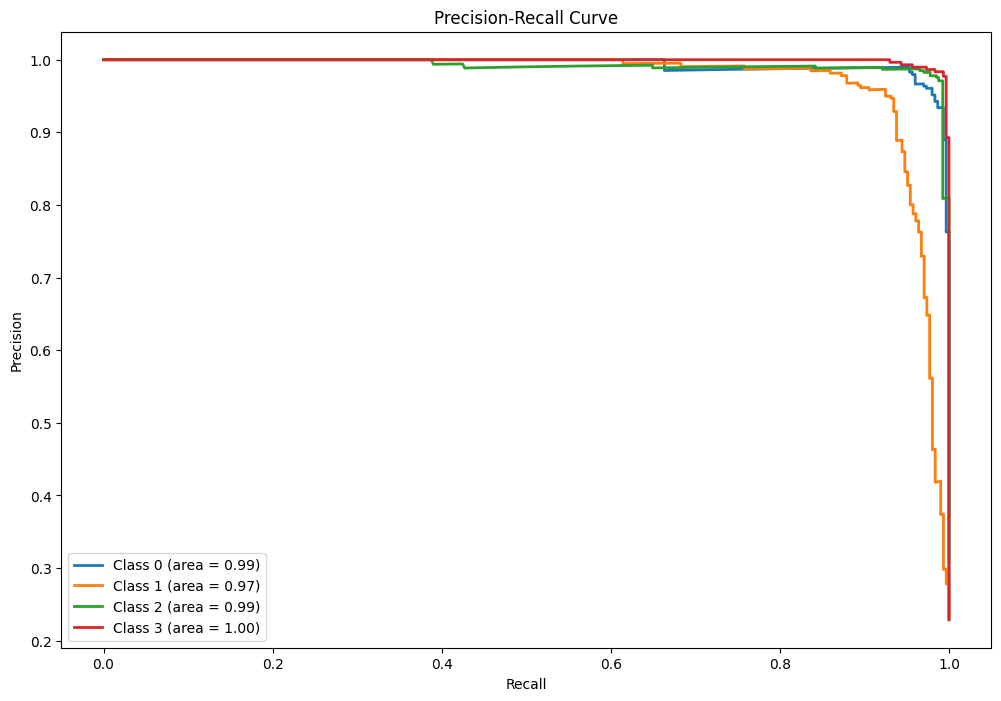

In [22]:
# Plot precision-recall curve for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (area = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

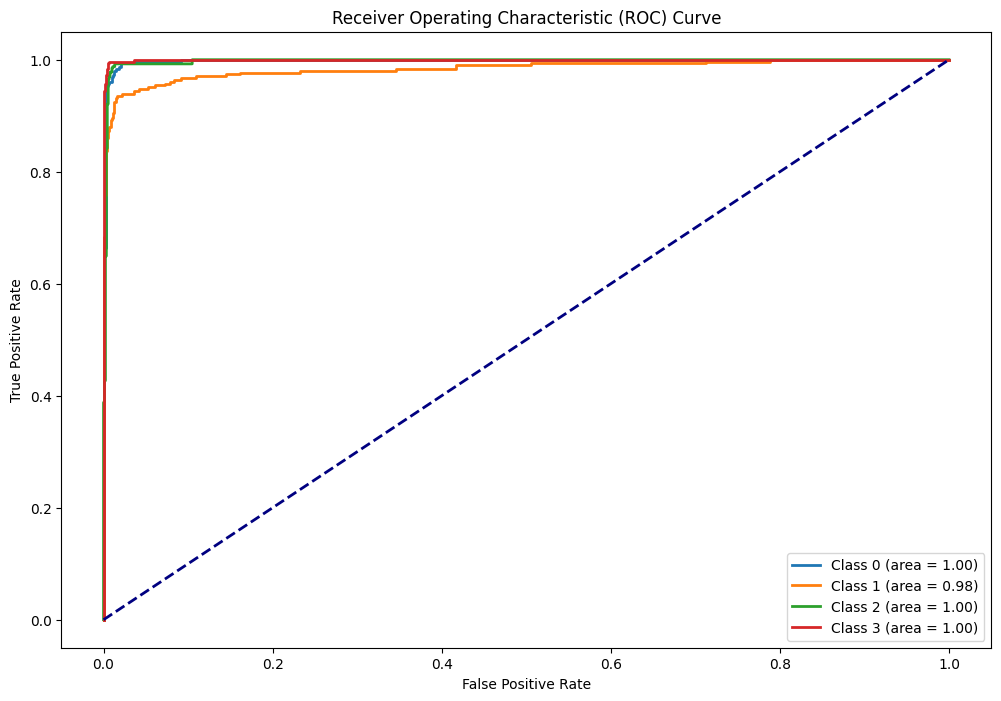

In [23]:
# Assuming y_true and Y_pred_prob are defined for multi-class
n_classes = Y_pred_prob.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize lists to store fpr, tpr, and roc_auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

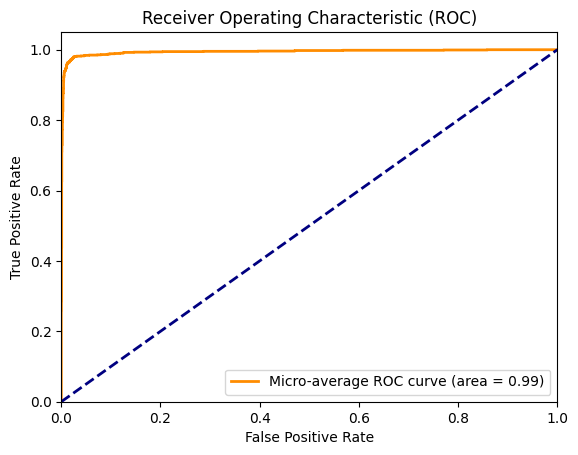

Micro-average ROC AUC: 0.99


In [24]:
# Assuming y_true and Y_pred_prob are defined for multi-class
n_classes = Y_pred_prob.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), Y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

# Plot micro-average ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Micro-average ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print micro-average ROC AUC score
print(f"Micro-average ROC AUC: {roc_auc_score(y_true_bin.ravel(), Y_pred_prob.ravel()):.2f}")